# Objectif :
Un algorithme de classification avec des perfs **>70 % recall** et > **50 % f1-score**

# Checklist de base :

## Analyse de forme :
* **Variable cible** : `TARGET` : Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)
* **Dimensions** : 307511 lignes 121 colonnes + 1 colonne ID Client
* Types de variables :
* Valeurs manquantes : les variables de type _AVG, _MODE, _MEDI sont très peu complètes.
OWN_CAR_AGE peu complète car la plupart des clients n'ont pas de voiture (soluce: -1)
EXT_SOURCE_1 très peu complète mais très utile malgré tout car c'est un score de qualité de l'emprunteur

In [1]:
# code pour importer les descriptions de variable

In [2]:
# Importations
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from styles import *

In [3]:
# Initialisation
train = pd.read_csv('../02_data/application_train.csv')
#test = pd.read_csv('../02_data/application_test.csv')
df = train.copy()

id_error_msg = lambda x: '`SK_ID_CURR` is not unic for {} set!'.format(x)
assert len(df.SK_ID_CURR.unique()) == df.shape[0], id_error_msg('train')
#assert len(test.SK_ID_CURR.unique()) == test.shape[0], id_error_msg('test')
df.set_index('SK_ID_CURR', inplace=True)
#test.set_index('SK_ID_CURR', inplace=True)

In [3]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print('Training set dimensions:', df.shape)

Training set dimensions: (307511, 121)


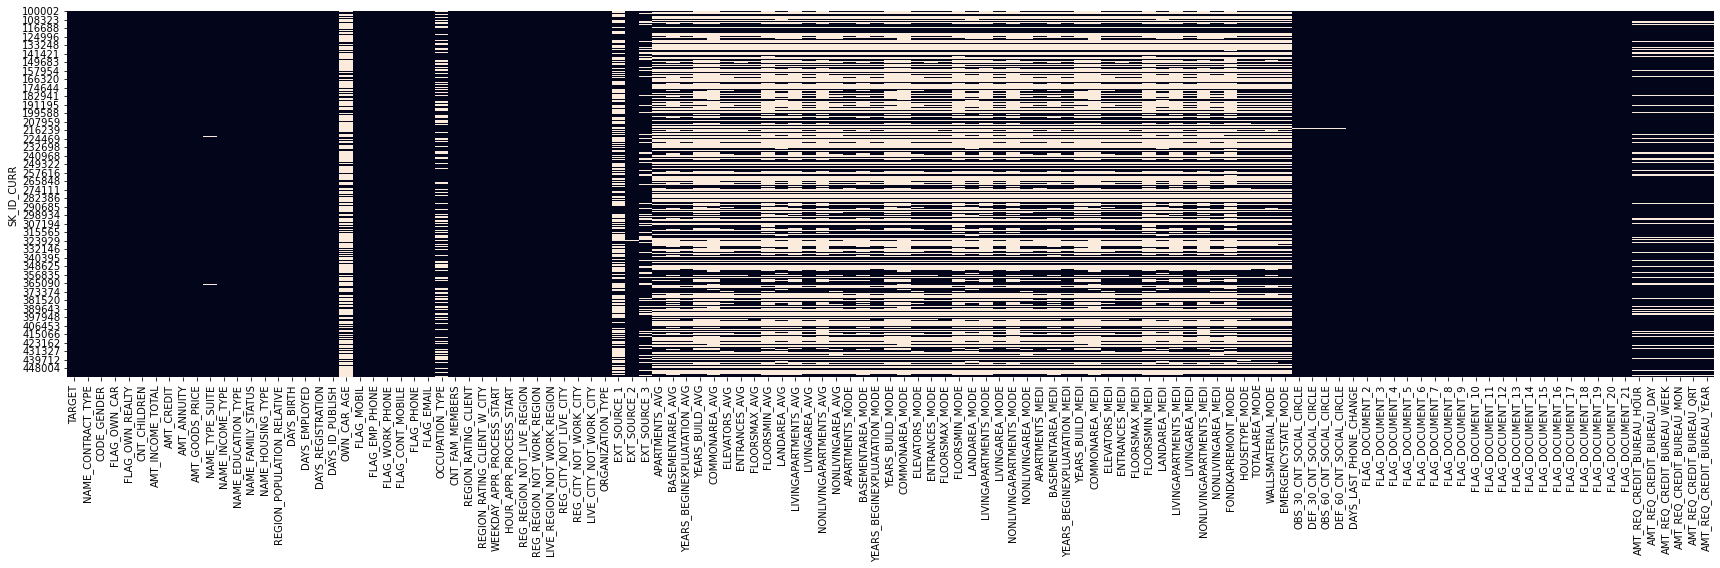

In [6]:
plt.figure(figsize=(24,8), facecolor='white')
sns.heatmap(df.isna(), cbar=False)
plt.tight_layout()
plt.savefig('isna.png')

In [9]:
with pd.option_context('display.max_rows', None):
    print((df.isna().sum() / df.shape[0]).sort_values(ascending=False))

COMMONAREA_AVG                  0.698723
COMMONAREA_MODE                 0.698723
COMMONAREA_MEDI                 0.698723
NONLIVINGAPARTMENTS_AVG         0.694330
NONLIVINGAPARTMENTS_MODE        0.694330
NONLIVINGAPARTMENTS_MEDI        0.694330
FONDKAPREMONT_MODE              0.683862
LIVINGAPARTMENTS_MEDI           0.683550
LIVINGAPARTMENTS_AVG            0.683550
LIVINGAPARTMENTS_MODE           0.683550
FLOORSMIN_AVG                   0.678486
FLOORSMIN_MODE                  0.678486
FLOORSMIN_MEDI                  0.678486
YEARS_BUILD_AVG                 0.664978
YEARS_BUILD_MEDI                0.664978
YEARS_BUILD_MODE                0.664978
OWN_CAR_AGE                     0.659908
LANDAREA_MEDI                   0.593767
LANDAREA_AVG                    0.593767
LANDAREA_MODE                   0.593767
BASEMENTAREA_MEDI               0.585160
BASEMENTAREA_AVG                0.585160
BASEMENTAREA_MODE               0.585160
EXT_SOURCE_1                    0.563811
NONLIVINGAREA_AV

# Possession d'une voiture et âge de la voiture

In [11]:
df.FLAG_OWN_CAR.value_counts()

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64

In [31]:
pd.crosstab(df.TARGET, df.FLAG_OWN_CAR, normalize='index')

FLAG_OWN_CAR,N,Y
TARGET,,
0,0.656824,0.343176
1,0.694824,0.305176


In [12]:
df.OWN_CAR_AGE.describe()

count    104582.000000
mean         12.061091
std          11.944812
min           0.000000
25%           5.000000
50%           9.000000
75%          15.000000
max          91.000000
Name: OWN_CAR_AGE, dtype: float64

In [32]:
df[df.OWN_CAR_AGE == 0].shape[0]

2134

In [18]:
try:
    assert df[df.FLAG_OWN_CAR == 'N'].FLAG_OWN_CAR.count()\
           == df.OWN_CAR_AGE.isna().sum()
except AssertionError:
    print('No. Non-car-owners:', df[df.FLAG_OWN_CAR == 'N'].shape[0])
    print('No. Customers with unknown car age:', df.OWN_CAR_AGE.isna().sum())

No. Non-car-owners: 202924
No. Customers with unknown car age: 202929


In [19]:
df.loc[df.FLAG_OWN_CAR == 'N', 'OWN_CAR_AGE'] = -1.0

In [20]:
df.OWN_CAR_AGE.describe()

count    307506.000000
mean          3.442043
std           9.317221
min          -1.000000
25%          -1.000000
50%          -1.000000
75%           5.000000
max          91.000000
Name: OWN_CAR_AGE, dtype: float64

In [21]:
with pd.option_context('display.max_rows', None):
    print((df.isna().sum() / df.shape[0]).sort_values(ascending=False))

COMMONAREA_MEDI                 0.698723
COMMONAREA_AVG                  0.698723
COMMONAREA_MODE                 0.698723
NONLIVINGAPARTMENTS_MODE        0.694330
NONLIVINGAPARTMENTS_AVG         0.694330
NONLIVINGAPARTMENTS_MEDI        0.694330
FONDKAPREMONT_MODE              0.683862
LIVINGAPARTMENTS_MODE           0.683550
LIVINGAPARTMENTS_AVG            0.683550
LIVINGAPARTMENTS_MEDI           0.683550
FLOORSMIN_AVG                   0.678486
FLOORSMIN_MODE                  0.678486
FLOORSMIN_MEDI                  0.678486
YEARS_BUILD_MEDI                0.664978
YEARS_BUILD_MODE                0.664978
YEARS_BUILD_AVG                 0.664978
LANDAREA_MEDI                   0.593767
LANDAREA_MODE                   0.593767
LANDAREA_AVG                    0.593767
BASEMENTAREA_MEDI               0.585160
BASEMENTAREA_AVG                0.585160
BASEMENTAREA_MODE               0.585160
EXT_SOURCE_1                    0.563811
NONLIVINGAREA_MODE              0.551792
NONLIVINGAREA_AV

## Corrélations avec la variable cible

In [22]:
correlations = df.corr()['TARGET']

In [24]:
correlations = correlations.drop(['TARGET'], axis=0)
with pd.option_context('display.max_rows', None):
    print(correlations.sort_values(ascending=False))

DAYS_BIRTH                      0.078239
REGION_RATING_CLIENT_W_CITY     0.060893
REGION_RATING_CLIENT            0.058899
DAYS_LAST_PHONE_CHANGE          0.055218
DAYS_ID_PUBLISH                 0.051457
REG_CITY_NOT_WORK_CITY          0.050994
FLAG_EMP_PHONE                  0.045982
REG_CITY_NOT_LIVE_CITY          0.044395
FLAG_DOCUMENT_3                 0.044346
DAYS_REGISTRATION               0.041975
LIVE_CITY_NOT_WORK_CITY         0.032518
DEF_30_CNT_SOCIAL_CIRCLE        0.032248
DEF_60_CNT_SOCIAL_CIRCLE        0.031276
FLAG_WORK_PHONE                 0.028524
AMT_REQ_CREDIT_BUREAU_YEAR      0.019930
CNT_CHILDREN                    0.019187
CNT_FAM_MEMBERS                 0.009308
OBS_30_CNT_SOCIAL_CIRCLE        0.009131
OBS_60_CNT_SOCIAL_CIRCLE        0.009022
REG_REGION_NOT_WORK_REGION      0.006942
REG_REGION_NOT_LIVE_REGION      0.005576
FLAG_DOCUMENT_2                 0.005417
FLAG_DOCUMENT_21                0.003709
LIVE_REGION_NOT_WORK_REGION     0.002819
AMT_REQ_CREDIT_B

# EDA avec prétraitement des données

In [ ]:
from preprocessing import preprocessor as prep
from preprocessing import preprocessor_no_scaler as prep_no_scl
from preprocessing import get_preprocessed_set_column_names as get_col_names

df_trans = pd.DataFrame(prep_no_scl.fit_transform(df.iloc[:, 1:]),
                        columns=get_col_names(prep_no_scl))
df_trans_scl = pd.DataFrame(prep.fit_transform(df.iloc[:, 1:]),
                            columns=get_col_names(prep))

In [4]:
df_trans

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced_house,HOUSETYPE_MODE_unknown,WALLSMATERIAL_MODE_block,WALLSMATERIAL_MODE_mixed,WALLSMATERIAL_MODE_monolithic,WALLSMATERIAL_MODE_others,WALLSMATERIAL_MODE_panel,WALLSMATERIAL_MODE_stone_or_brick,WALLSMATERIAL_MODE_unknown,WALLSMATERIAL_MODE_wooden
0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,-9833.0,-2437.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,-4311.0,-3458.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327.0,-236.0,-8456.0,-1982.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
307507,0.0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775.0,365243.0,-4388.0,-4090.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
307508,0.0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966.0,-7921.0,-6737.0,-5150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
307509,0.0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961.0,-4786.0,-2562.0,-931.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
df_trans['TARGET'] = df['TARGET'].values
df_trans.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_unknown,WALLSMATERIAL_MODE_block,WALLSMATERIAL_MODE_mixed,WALLSMATERIAL_MODE_monolithic,WALLSMATERIAL_MODE_others,WALLSMATERIAL_MODE_panel,WALLSMATERIAL_MODE_stone_or_brick,WALLSMATERIAL_MODE_unknown,WALLSMATERIAL_MODE_wooden,TARGET
0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,-9833.0,-2437.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,-4311.0,-3458.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [7]:
df_trans.iloc[:,:-1].head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced_house,HOUSETYPE_MODE_unknown,WALLSMATERIAL_MODE_block,WALLSMATERIAL_MODE_mixed,WALLSMATERIAL_MODE_monolithic,WALLSMATERIAL_MODE_others,WALLSMATERIAL_MODE_panel,WALLSMATERIAL_MODE_stone_or_brick,WALLSMATERIAL_MODE_unknown,WALLSMATERIAL_MODE_wooden
0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,-9833.0,-2437.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,-4311.0,-3458.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
print(df.AMT_INCOME_TOTAL.describe())
print(df.AMT_INCOME_TOTAL.isnull().sum())

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64
0


In [20]:
print(df.AMT_CREDIT.describe())
print(df.AMT_CREDIT.isnull().sum())

count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64
0


In [21]:
print(df.AMT_ANNUITY.describe())
print(df.AMT_ANNUITY.isnull().sum())

count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64
12


# Corrélations entre variables

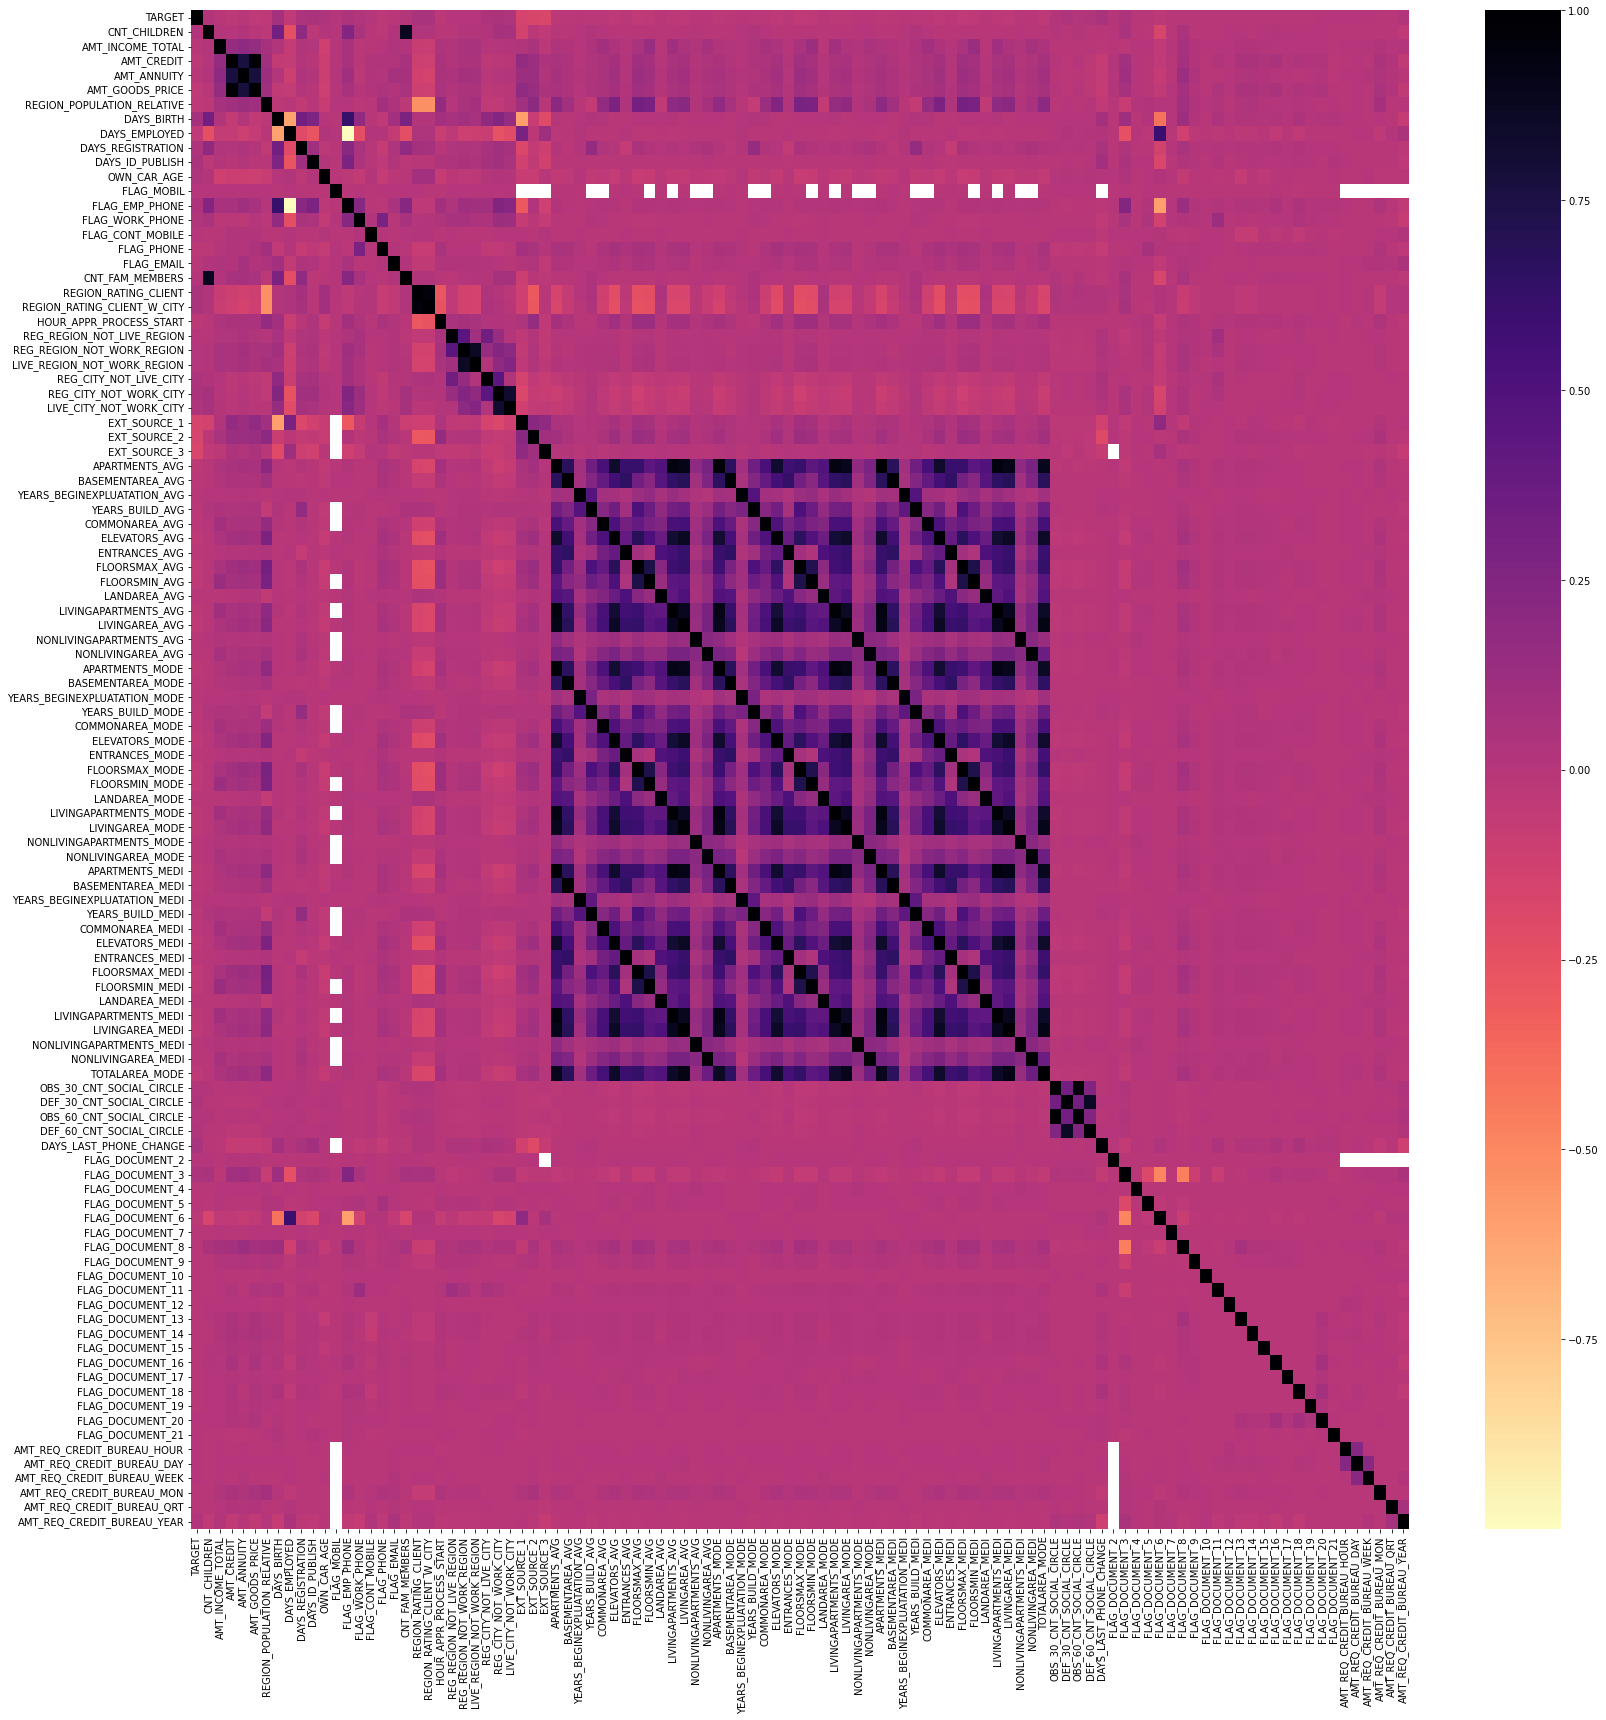

In [7]:
plt.figure(figsize=(24,24), facecolor='white')
sns.heatmap(df.corr(), cmap=plt.cm.magma_r)
plt.tight_layout()
plt.savefig('corr_heatmap.png')

In [6]:
# Find correlations with the target and sort
correlations = df_trans.corr()['TARGET'].sort_values()

In [7]:
correlations = correlations.drop(['TARGET'], axis=0)

In [25]:
abs_corr = correlations.apply(lambda x: np.abs(x)).sort_values(ascending=False)

In [27]:
with pd.option_context('display.max_rows', None):
    print(abs_corr)

EXT_SOURCE_3                    0.178919
EXT_SOURCE_2                    0.160472
EXT_SOURCE_1                    0.155317
DAYS_BIRTH                      0.078239
REGION_RATING_CLIENT_W_CITY     0.060893
REGION_RATING_CLIENT            0.058899
DAYS_LAST_PHONE_CHANGE          0.055218
DAYS_ID_PUBLISH                 0.051457
REG_CITY_NOT_WORK_CITY          0.050994
FLAG_EMP_PHONE                  0.045982
DAYS_EMPLOYED                   0.044932
REG_CITY_NOT_LIVE_CITY          0.044395
FLAG_DOCUMENT_3                 0.044346
FLOORSMAX_AVG                   0.044003
FLOORSMAX_MEDI                  0.043768
FLOORSMAX_MODE                  0.043226
DAYS_REGISTRATION               0.041975
AMT_GOODS_PRICE                 0.039645
REGION_POPULATION_RELATIVE      0.037227
ELEVATORS_AVG                   0.034199
ELEVATORS_MEDI                  0.033863
FLOORSMIN_AVG                   0.033614
FLOORSMIN_MEDI                  0.033394
LIVINGAREA_AVG                  0.032997
LIVINGAREA_MEDI 

In [26]:
with pd.option_context('display.max_rows', None):
    print(abs_corr[abs_corr < 0.005])

FLAG_DOCUMENT_9                0.004352
FLAG_DOCUMENT_11               0.004229
AMT_INCOME_TOTAL               0.003982
FLAG_DOCUMENT_21               0.003709
FLAG_DOCUMENT_17               0.003378
NONLIVINGAPARTMENTS_AVG        0.003176
LIVE_REGION_NOT_WORK_REGION    0.002819
NONLIVINGAPARTMENTS_MEDI       0.002757
AMT_REQ_CREDIT_BUREAU_DAY      0.002704
FLAG_DOCUMENT_4                0.002672
AMT_REQ_CREDIT_BUREAU_QRT      0.002022
FLAG_EMAIL                     0.001758
NONLIVINGAPARTMENTS_MODE       0.001557
FLAG_DOCUMENT_7                0.001520
FLAG_DOCUMENT_10               0.001414
FLAG_DOCUMENT_19               0.001358
OWN_CAR_AGE                    0.001097
AMT_REQ_CREDIT_BUREAU_HOUR     0.000930
AMT_REQ_CREDIT_BUREAU_WEEK     0.000788
FLAG_DOCUMENT_12               0.000756
FLAG_MOBIL                     0.000534
FLAG_CONT_MOBILE               0.000370
FLAG_DOCUMENT_5                0.000316
FLAG_DOCUMENT_20               0.000215
Name: TARGET, dtype: float64


In [ ]:
# variables corrélées les unes aux autres, mat_corr
# tester importance features

In [12]:
print(correlations.apply(lambda x: np.abs(x))[-10:])

FLAG_EMP_PHONE                                        0.045982
NAME_EDUCATION_TYPE_secondary_or_secondary_special    0.049824
REG_CITY_NOT_WORK_CITY                                0.050994
DAYS_ID_PUBLISH                                       0.051457
DAYS_LAST_PHONE_CHANGE                                0.055218
NAME_INCOME_TYPE_working                              0.057481
REGION_RATING_CLIENT                                  0.058899
REGION_RATING_CLIENT_W_CITY                           0.060893
DAYS_BIRTH                                            0.078239
TARGET                                                1.000000
Name: TARGET, dtype: float64


In [4]:
X_scl = df_trans_scl.values
print(X_scl.var(axis=0))

[1.44448088e-03 4.10927498e-06 1.00996288e-02 3.19501489e-03
 8.48302708e-03 3.66802619e-02 6.05143786e-02 1.35951792e-01
 2.03885872e-02 4.39879059e-02 6.11355051e-03 2.29732128e-03
 6.47786679e-02 6.31859256e-02 2.01618632e-02 2.16194300e-02
 4.98358438e-02 3.80757059e-02 4.74986938e-05 1.72097226e-04
 4.77553478e-05 2.27172798e-04 3.71097209e-02 3.80386548e-04
 1.31069304e-04 5.68391061e-04 1.00702485e-03 8.12703842e-06
 4.98729896e-03 5.77010424e-03 2.81925431e-03 1.79644362e-03
 4.29907715e-03 1.74179461e-03 8.45836615e-03 4.96996966e-03
 1.05104363e-02 8.37328879e-03 2.67736984e-03 2.71206042e-03
 6.08858393e-03 6.96404921e-04 2.16638728e-03 6.10675729e-03
 2.83740315e-03 1.84126502e-03 4.20914420e-03 1.86596163e-03
 9.96210329e-03 5.03373350e-03 1.14485254e-02 8.54947983e-03
 2.82489877e-03 2.91948267e-03 6.56080992e-03 7.03071235e-04
 2.36292280e-03 5.96613858e-03 4.80891258e-03 2.16096979e-03
 5.16802782e-03 2.05083894e-03 9.55041684e-03 5.07587637e-03
 1.11487664e-02 8.435583

In [17]:
var_pct = ['{:.3g}%'.format(x*100) for x in X_scl.var(axis=0)]
for c,v in zip(df_trans.columns, var_pct):
    print(c, v)

CNT_CHILDREN 0.144%
AMT_INCOME_TOTAL 0.000411%
AMT_CREDIT 1.01%
AMT_ANNUITY 0.32%
AMT_GOODS_PRICE 0.848%
REGION_POPULATION_RELATIVE 3.67%
DAYS_BIRTH 6.05%
DAYS_EMPLOYED 13.6%
DAYS_REGISTRATION 2.04%
DAYS_ID_PUBLISH 4.4%
OWN_CAR_AGE 0.611%
CNT_FAM_MEMBERS 0.23%
REGION_RATING_CLIENT 6.48%
REGION_RATING_CLIENT_W_CITY 6.32%
HOUR_APPR_PROCESS_START 2.02%
EXT_SOURCE_1 2.16%
EXT_SOURCE_2 4.98%
EXT_SOURCE_3 3.81%
OBS_30_CNT_SOCIAL_CIRCLE 0.00475%
DEF_30_CNT_SOCIAL_CIRCLE 0.0172%
OBS_60_CNT_SOCIAL_CIRCLE 0.00478%
DEF_60_CNT_SOCIAL_CIRCLE 0.0227%
DAYS_LAST_PHONE_CHANGE 3.71%
AMT_REQ_CREDIT_BUREAU_HOUR 0.038%
AMT_REQ_CREDIT_BUREAU_DAY 0.0131%
AMT_REQ_CREDIT_BUREAU_WEEK 0.0568%
AMT_REQ_CREDIT_BUREAU_MON 0.101%
AMT_REQ_CREDIT_BUREAU_QRT 0.000813%
AMT_REQ_CREDIT_BUREAU_YEAR 0.499%
APARTMENTS_AVG 0.577%
BASEMENTAREA_AVG 0.282%
YEARS_BEGINEXPLUATATION_AVG 0.18%
YEARS_BUILD_AVG 0.43%
COMMONAREA_AVG 0.174%
ELEVATORS_AVG 0.846%
ENTRANCES_AVG 0.497%
FLOORSMAX_AVG 1.05%
FLOORSMIN_AVG 0.837%
LANDAREA_AVG 0.